In [2]:
%pylab inline
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy import stats
from scipy.interpolate import interp1d

Populating the interactive namespace from numpy and matplotlib


In [3]:
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.table
import seaborn as sns

In [4]:
from matplotlib.font_manager import FontProperties
font = FontProperties()
font.set_family('serif')
font.set_size('large')

## Look at Data

In [5]:
filen = '/Users/parkerf/Research/SkyModel/BOSS_Sky/Analysis/FiberLocation/files/line_flux_files/complete_line_sum_file.fits'
hdu = fits.open(filen)

In [6]:
data = astropy.table.Table(hdu[1].data)

In [7]:
x = SkyCoord(ra = data['RA']*u.deg, dec = data['DEC']*u.deg, distance = 1000*u.AU)
data['HELIO_LON'] = astropy.table.Column(x.heliocentrictrueecliptic.lon.value)
data['HELIO_LAT'] = astropy.table.Column(x.heliocentrictrueecliptic.lat.value)

All data as function of ecliptic latitude and longitude for the bB band (, only looking at the mean values for each plate.

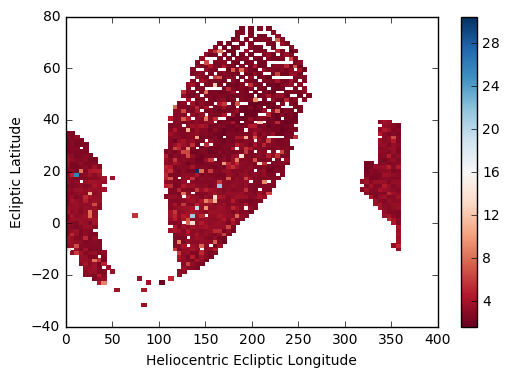

In [8]:
blue_data = data[data['mean_bB']>0]
H, xedges, yedges, binnumber = stats.binned_statistic_2d(blue_data['HELIO_LON'], blue_data['HELIO_LAT'], blue_data['mean_bB'], statistic = 'mean', bins = 75)
H = np.ma.masked_invalid(H)

XX, YY = np.meshgrid(xedges, yedges)
plt.pcolormesh(XX,YY,H.T,cmap = 'RdBu')
plt.colorbar()
plt.xlabel("Heliocentric Ecliptic Longitude")
plt.ylabel("Ecliptic Latitude")

Now, just look at dark time data so we don't have the bright moon factor in.

In [9]:
Dark = data[(data['AIRMASS']<1.4) & (data['MOON_ALT']< -18) & (data['SUN_ALT'] < -18) & (data['GAL_LAT'] > 10)]
blue_Dark = Dark[(Dark['mean_bB']>0)] #Only looking at Blue Data

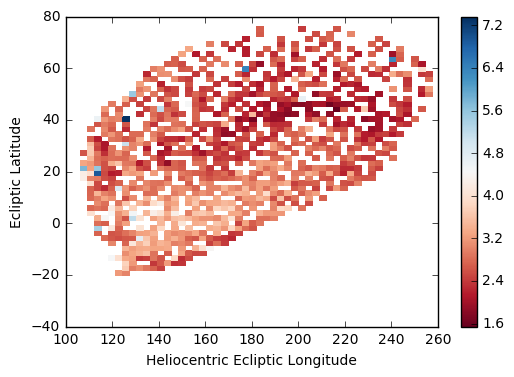

In [86]:
H, xedges, yedges, binnumber = stats.binned_statistic_2d(blue_Dark['HELIO_LON'], blue_Dark['HELIO_LAT'], blue_Dark['mean_bB'], statistic = 'mean', bins = 50)
H = np.ma.masked_invalid(H)

XX, YY = np.meshgrid(xedges, yedges)
plt.pcolormesh(XX,YY,H.T,cmap = 'RdBu')
plt.colorbar()
plt.xlabel("Heliocentric Ecliptic Longitude")
plt.ylabel("Ecliptic Latitude")

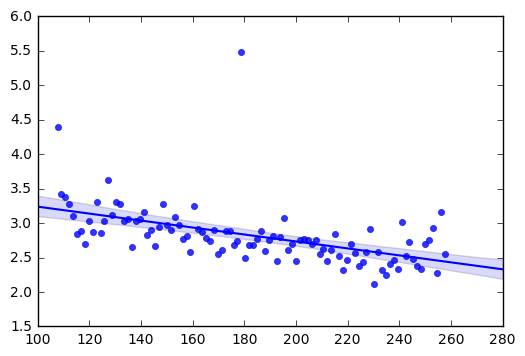

In [87]:
means, edges, bins = stats.binned_statistic(blue_Dark['HELIO_LON'],  blue_Dark['mean_bB'], statistic = 'mean', bins = 100)
sns.regplot(x = edges[1:], y = means)

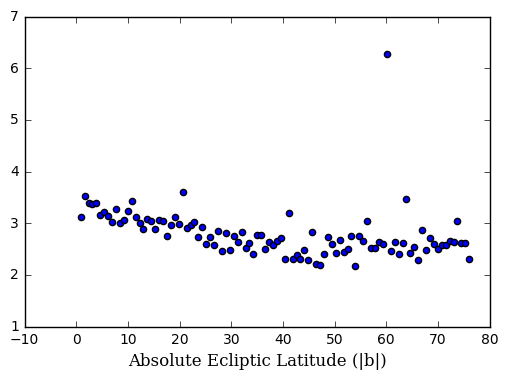

In [88]:
means, edges, bins = stats.binned_statistic(np.abs(blue_Dark['HELIO_LAT']),  blue_Dark['bB'], statistic = 'mean', bins = 100)
plt.scatter(x = edges[1:], y = means)
plt.xlabel("Absolute Ecliptic Latitude (|b|)", fontproperties = font)

### Look at outliers

In [10]:
dark_mean = np.mean(blue_Dark['mean_bB'])

In [11]:
Bright_in_Dark = blue_Dark[blue_Dark['mean_bB']>=2.5*dark_mean]

In [97]:
np.unique(Bright_in_Dark['PLATE'])

3659
3676
3680
3683
3785
5715
6037
7101
7338
7339


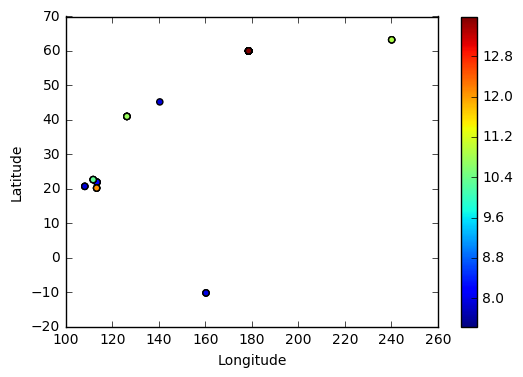

In [173]:
lon = []
lat = []
bb = []
for image in np.unique(Bright_in_Dark['IMG']):
    data = Bright_in_Dark[Bright_in_Dark['IMG'] == image][0]
    lon.append(data['HELIO_LON'])
    lat.append(data['HELIO_LAT'])
    bb.append(data['mean_bB'])
plt.scatter(lon,lat,c = bb)
plt.colorbar()
plt.xlabel("Longitude")
plt.ylabel("Latitude")

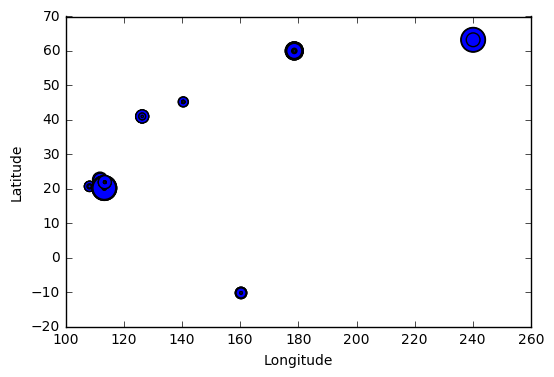

In [168]:
plt.scatter(Bright_in_Dark['HELIO_LON'], Bright_in_Dark['HELIO_LAT'], s = Bright_in_Dark['bB'])
#plt.colorbar()
plt.xlabel("Longitude")
plt.ylabel("Latitude")

In [12]:
outliers = Bright_in_Dark[Bright_in_Dark['bB']>3*Bright_in_Dark['mean_bB']]

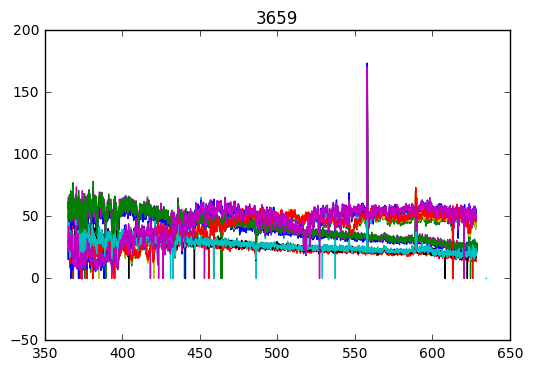

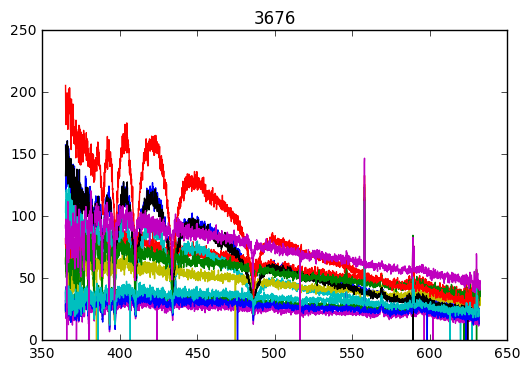

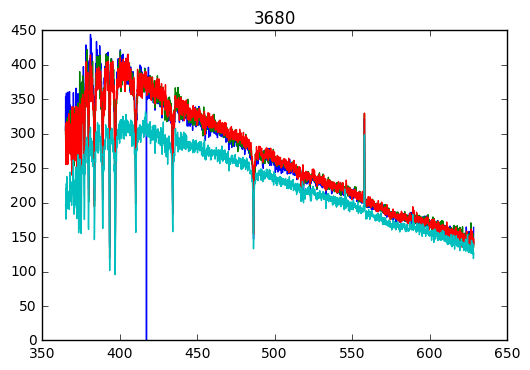

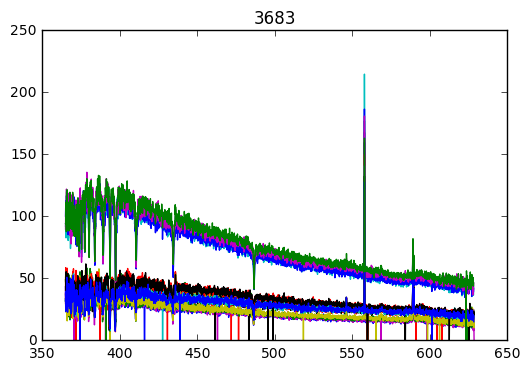

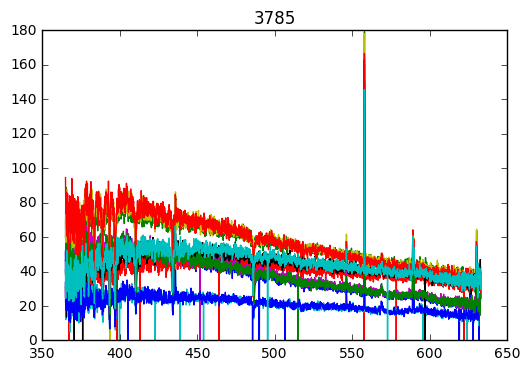

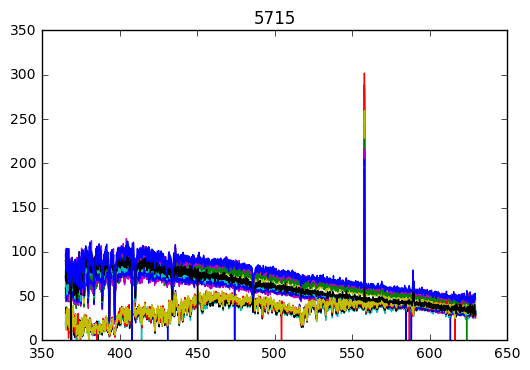

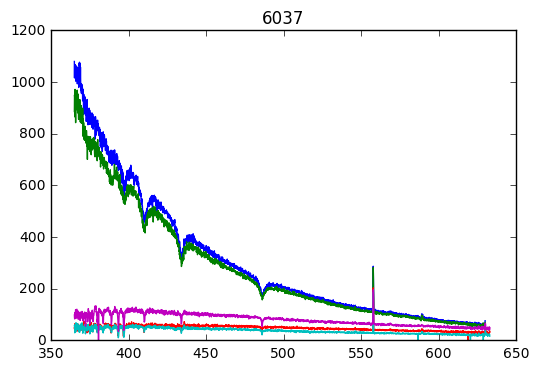

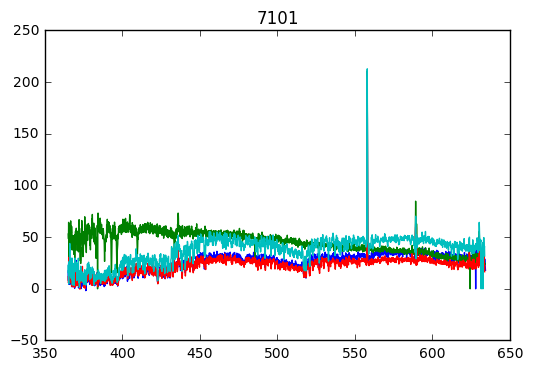

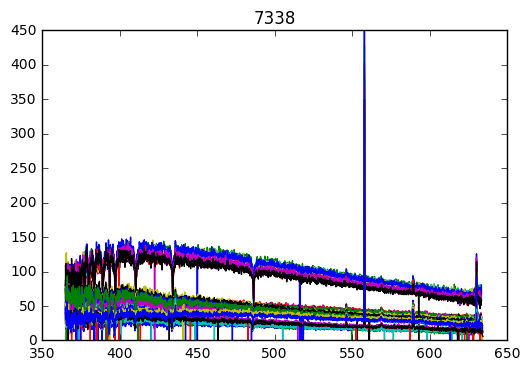

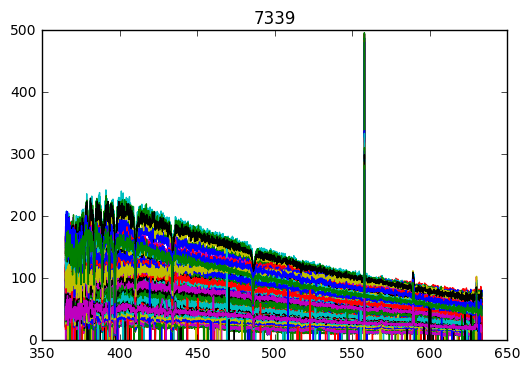

In [185]:
for plate in np.unique(outliers['PLATE']):
    data = np.load('/Volumes/PFagrelius_Backup/sky_data/sky_flux/%d_calibrated_sky.npy' % int(plate))
    these_outliers = outliers[outliers['PLATE'] == plate]
    plt.figure()
    for this_outlier in these_outliers:
        spectrum = data[this_outlier['SPECNO']]
        plt.plot(spectrum['WAVE'], spectrum['SKY'])
    plt.title(plate)

In [180]:
len(np.unique(Dark[Dark['bB']>3*Dark['mean_bB']]['PLATE']))

58

In [130]:
print(np.unique(Bright_in_Dark[(Bright_in_Dark['HELIO_LAT']>15)&(Bright_in_Dark['HELIO_LAT']<30)]['PLATE']))
group_1 = np.unique(Bright_in_Dark[(Bright_in_Dark['HELIO_LAT']>15)&(Bright_in_Dark['HELIO_LAT']<30)]['IMG'])

PLATE
-----
 3659
 3676
 3680
 3683


In [131]:
print(np.unique(Bright_in_Dark[(Bright_in_Dark['HELIO_LAT']<0)]['PLATE']))
group_2 = np.unique(Bright_in_Dark[(Bright_in_Dark['HELIO_LAT']<0)]['IMG'])

PLATE
-----
 3785


In [132]:
print(np.unique(Bright_in_Dark[(Bright_in_Dark['HELIO_LON']>120)&(Bright_in_Dark['HELIO_LON']<150)]['PLATE']))
group_3 = np.unique(Bright_in_Dark[(Bright_in_Dark['HELIO_LON']>120)&(Bright_in_Dark['HELIO_LON']<150)]['IMG'])

PLATE
-----
 5715
 7101


In [133]:
print(np.unique(Bright_in_Dark[(Bright_in_Dark['HELIO_LON']>170)]['PLATE']))
group_4 = np.unique(Bright_in_Dark[(Bright_in_Dark['HELIO_LON']>170)]['IMG'])

PLATE
-----
 6037
 7338
 7339


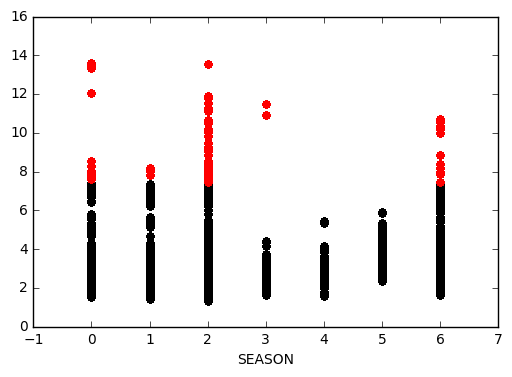

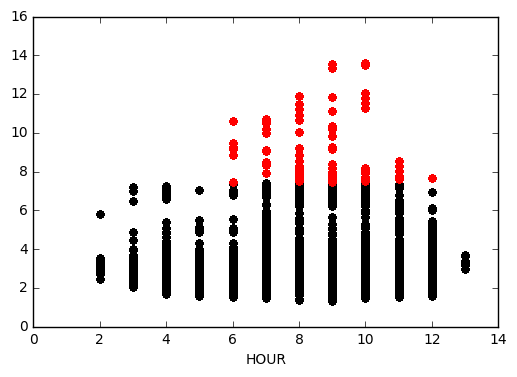

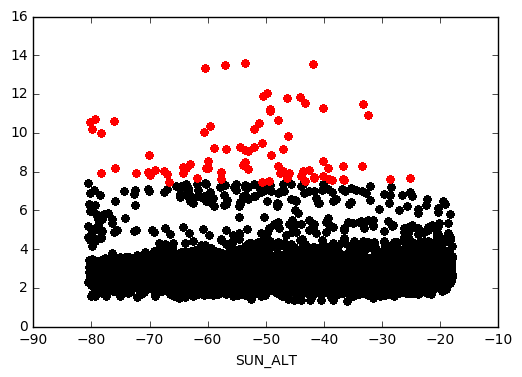

In [127]:
for param in ['SEASON','HOUR','SUN_ALT']:
    plt.figure()
    plt.scatter( blue_Dark[param],blue_Dark['mean_bB'],color='black')
    plt.scatter( Bright_in_Dark[param],Bright_in_Dark['mean_bB'],color='red')
    plt.xlabel(param)

Clouds?

In [148]:
import pandas as pd
cloud_data = np.load('/Users/parkerf/Research/SkyModel/BOSS_Sky/BrightSky/clouds/phot_rec.npy')
df = pd.DataFrame(cloud_data)

In [149]:
def get_cloud_data(line): 
    clouds = df[(df['STARTTAI']<= line['TAI-BEG']) & (df['ENDTAI']>line['TAI-BEG'])]['PHOTOMETRIC'].values
    if len(clouds) == 0:
        clouds = df[(df['STARTTAI']< line['TAI-END']) & (df['ENDTAI']>=line['TAI-END'])]['PHOTOMETRIC'].values
    if len(clouds) == 0:
        clouds = 0.5
    
    return clouds

In [150]:
clouds = [get_cloud_data(line) for line in Bright_in_Dark]

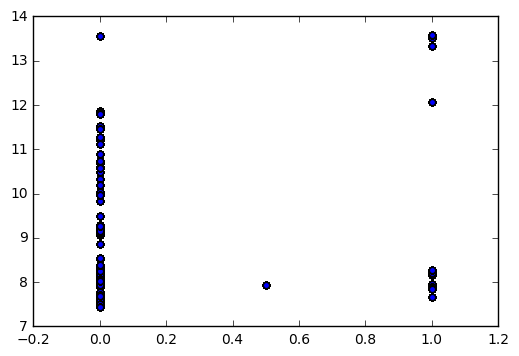

In [153]:
plt.scatter(clouds, Bright_in_Dark['mean_bB'])

Let's look at these spectra

In [137]:
Mhdu = fits.open('/Users/parkerf/Research/SkyModel/BOSS_Sky/Analysis/MetaData/good_meta_rich.fits')
MetaData = astropy.table.Table(Mhdu[1].data)
def get_specnos(plate, image):
    this_meta = MetaData[(MetaData['PLATE'] == plate) & (MetaData['IMG'] == image) & ((MetaData['CAMERAS'] == 'b1')|(MetaData['CAMERAS'] == 'b2'))]
    specnos = this_meta['SPECNO']
    return np.array(specnos)

In [135]:
def make_mean_spectra(image):
    SKY_SPECTRA = []
    plate = np.unique(MetaData[MetaData['IMG'] == image]['PLATE'])
    data = np.load('/Volumes/PFagrelius_Backup/sky_data/sky_flux/%d_calibrated_sky.npy' % int(plate))
    specnos = get_specnos(plate, image)
    xx = np.linspace(365, 635, (635-365)*10)
    for specno in specnos:
        spectrum = data[specno]
        f = interp1d(spectrum['WAVE'], spectrum['SKY'], bounds_error=False, fill_value=0)
        sky = f(xx)
        SKY_SPECTRA.append(sky)

    mean_spectrum = np.mean(SKY_SPECTRA, axis=0)
    plt.plot(xx, mean_spectrum,label = image)

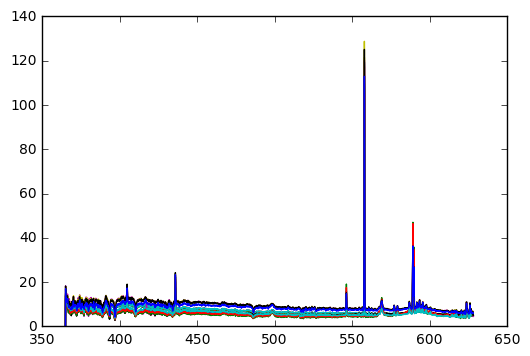

In [141]:
for image in group_1:
    make_mean_spectra(image)
#plt.legend()
plt.show()

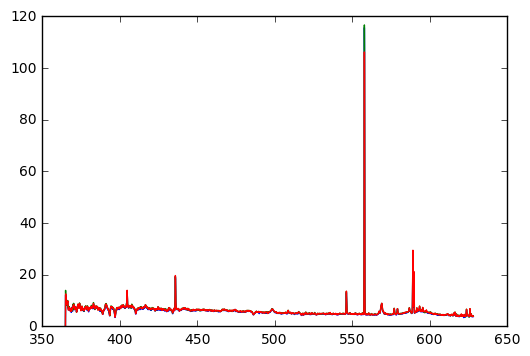

In [142]:
for image in group_2:
    make_mean_spectra(image)

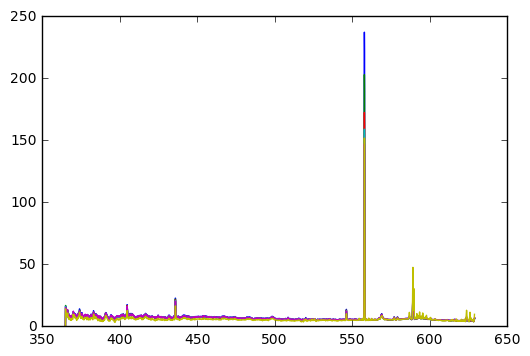

In [143]:
for image in group_3:
    make_mean_spectra(image)

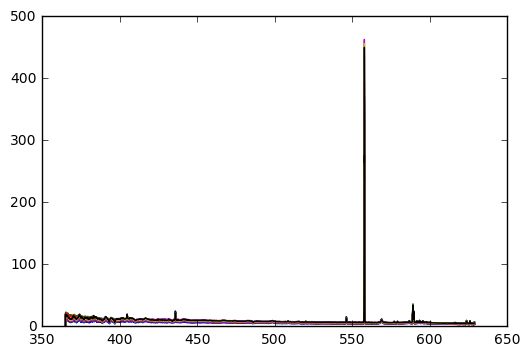

In [151]:
for image in group_4:
    make_mean_spectra(image)

## Remove Outliers

In [13]:
Clean_Dark = blue_Dark[blue_Dark['bB']<2*blue_Dark['mean_bB']]

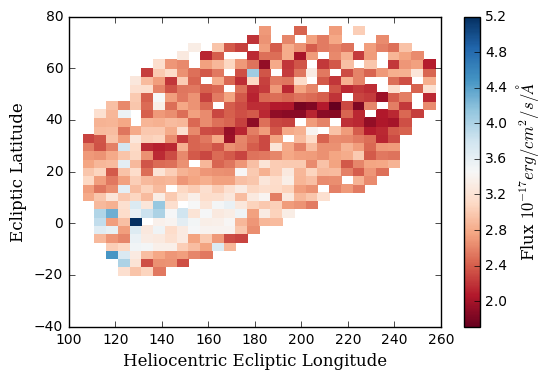

In [55]:
H, xedges, yedges, binnumber = stats.binned_statistic_2d(Clean_Dark['HELIO_LON'], Clean_Dark['HELIO_LAT'], Clean_Dark['bB'], statistic = 'mean', bins = 30)
H = np.ma.masked_invalid(H)

XX, YY = np.meshgrid(xedges, yedges)
plt.pcolormesh(XX,YY,H.T,cmap = 'RdBu')
cbar = plt.colorbar()
cbar.set_label('Flux $10^{-17} erg/cm^{2}/s/\AA$', fontproperties=font)
plt.xlabel("Heliocentric Ecliptic Longitude", fontproperties = font)
plt.ylabel("Ecliptic Latitude",fontproperties = font)

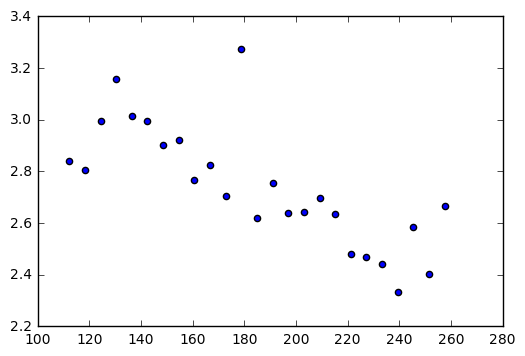

In [64]:
means, edges, bins = stats.binned_statistic(Clean_Dark['HELIO_LON'],  Clean_Dark['bB'], statistic = 'mean', bins = 25)
plt.scatter(edges[1:], means)

array([ 100.,  140.,  180.,  220.,  260.])

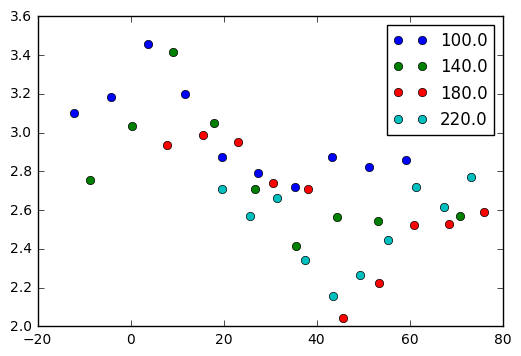

In [75]:
lons = array([ 100.,  140.,  180.,  220.])
for i, lon in enumerate(lons):
    if i<3:
        This_Data = Clean_Dark[(Clean_Dark['HELIO_LON']>lon)&(Clean_Dark['HELIO_LON']<lons[i+1])]
    else:
        This_Data = Clean_Dark[(Clean_Dark['HELIO_LON']>lon)]
    means, edges, bins = stats.binned_statistic(This_Data['ECL_LAT'],  This_Data['bB'], statistic = 'mean', bins = 10)
    plt.plot(edges[1:], means, 'o',label = lon)
plt.legend()

In [200]:
Geg = Clean_Dark[(Clean_Dark['HELIO_LAT']>-10)&(Clean_Dark['HELIO_LAT']<10)&(Clean_Dark['HELIO_LON']>170)&(Clean_Dark['HELIO_LON']<190)]

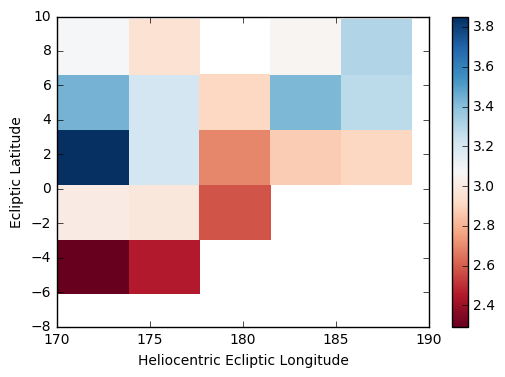

In [202]:
H, xedges, yedges, binnumber = stats.binned_statistic_2d(Geg['HELIO_LON'], Geg['HELIO_LAT'], Geg['bB'], statistic = 'mean', bins = 5)
H = np.ma.masked_invalid(H)

XX, YY = np.meshgrid(xedges, yedges)
plt.pcolormesh(XX,YY,H.T,cmap = 'RdBu')
plt.colorbar()
plt.xlabel("Heliocentric Ecliptic Longitude")
plt.ylabel("Ecliptic Latitude")

## Look at Model

In [14]:
sys.path.insert(0,'/Users/parkerf/Research/SkyModel/BOSS_Sky/Model/python/')

In [15]:
from sky_model import SkyModel

In [208]:
Sky = SkyModel()
Sky.run_model()

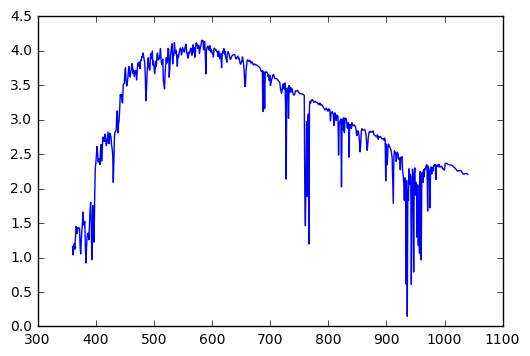

In [210]:
plt.plot(Sky.Model['wave_range'], Sky.Model['Zodi'])

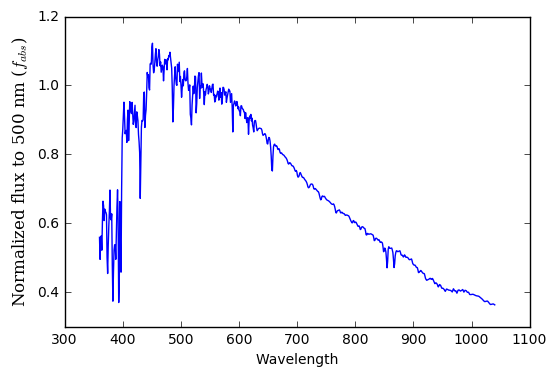

In [211]:
plt.plot(Sky.Model['wave_range'], Sky.Z.f_abs)
plt.ylabel("Normalized flux to 500 nm ($f_{abs}$)", fontproperties = font)
plt.xlabel("Wavelength")

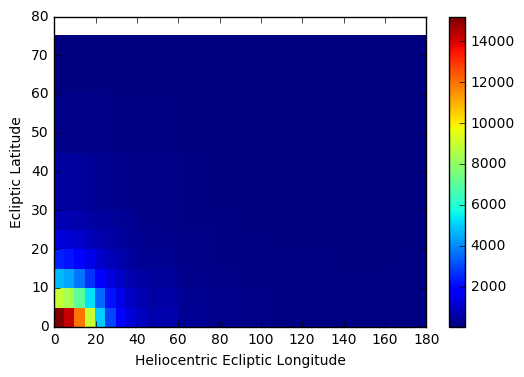

In [212]:
XX, YY = np.meshgrid(Sky.Z.ZodiLookup[0], Sky.Z.ZodiLookup[1])
plt.pcolormesh(XX,YY,Sky.Z.ZodiLookup[2].T)
plt.xlabel("Heliocentric Ecliptic Longitude")
plt.ylabel("Ecliptic Latitude")
plt.colorbar()

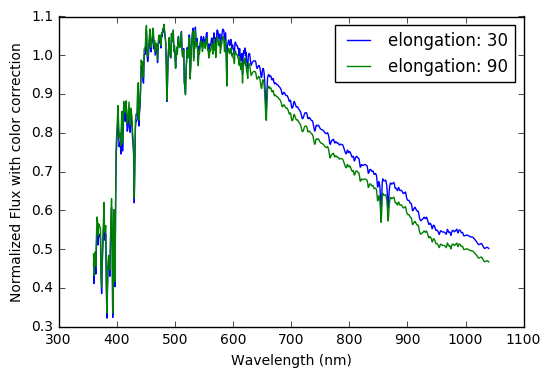

In [213]:
Sky.Z.elong = 30
Sky.Z.f_color()
plt.plot(Sky.Model['wave_range'], Sky.Z.f_abs*Sky.Z.f_co, label = "elongation: 30")
Sky.Z.elong = 90
Sky.Z.f_color()
plt.plot(Sky.Model['wave_range'], Sky.Z.f_abs*Sky.Z.f_co, label = "elongation: 90")
plt.legend()
plt.xlabel("Wavelength (nm)")
plt.ylabel("Normalized Flux with color correction")

## Test against real data

In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import astropy.table

In [18]:
Clean_Dark = astropy.table.Table(Clean_Dark)

In [19]:
Clean_Dark[0]

PLATE,SPECNO,IMG,FIB,XFOCAL_x,YFOCAL_x,FIBER_RA,FIBER_DEC,MJD,TAI-BEG,TAI-END,RA,DEC,CAMERAS,AIRMASS,ALT,AZ,EXPTIME,SEEING20,SEEING50,SEEING80,AIRTEMP,DEWPOINT,DUSTA,DUSTB,WINDD25M,WINDS25M,GUSTD,GUSTS,HUMIDITY,PRESSURE,WINDD,WINDS,MOON_LAT,MOON_LON,SUN_LAT,SUN_LON,MOON_ALT,MOON_AZ,SUN_ALT,SUN_AZ,MOON_D,MOON_SEP,SUN_MOON_SEP,SUN_ELONG,DAYS2FULL,ECL_LAT,ECL_LON,GAL_LAT,GAL_LON,AZ_CALC,FLI,SEASON,HOUR,SOLARFLUX,QUALITY,XFOCAL_y,YFOCAL_y,THROUGHPUT,A,OH6,rA,OH4,OH,Hg,bD,rD,rB,OI,bB,B,red_D,bC,x,mean_OH4,mean_A,mean_bD,mean_OI,mean_rA,mean_bC,mean_bB,mean_red_D,mean_Hg,mean_OH,mean_rD,mean_OH6,mean_rB,mean_B,HELIO_LON,HELIO_LAT
int32,int32,int32,int32,float32,float32,float32,float32,float64,float64,float64,float64,float64,str2,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,int32,int32,float32,str4,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64
4026,204,114934,230,14.9529,-159.832,220.092,-2.73664,55325.0,4780103189.0,4780104089.81,220.02286,-2.000578,b1,1.21755,55.116,4.427,900.81,1.4163,1.5573,1.7004,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0031082,254.146,-0.0096115,280.6,-35.1956,61.6021,-39.2318,349.566,404512.317366,131.502850492,55.9611582994,163.637925146,18.6954,12.9218,218.253,50.8439,349.198,175.564,0.052351,2,6,75.7333,good,14.952892,-159.83166,39646.0,0.0,0.0,0.0,0.0,0.0,106.277,2.33794,0.0,0.0,466.702,2.76796,0.0,0.0,2.07094,236121,0.0,0.0,2.3135,463.063,0.0,2.03794,2.76574,0.0,103.888,0.0,0.0,0.0,0.0,0.0,218.255987495,12.9228242223


In [23]:
Measured = []
Mod = []
for i in np.random.randint(len(Clean_Dark),size=10):
    point = Clean_Dark[i]

    Measured.append(point['mean_bB'])
    SM = SkyModel(point)
    SM.run_model()
    idx = np.where((SM.Model['wave_range']>450)&(SM.Model['wave_range']<475))
    bB = np.mean(SM.Model['Zodi'][idx])
    Mod.append(bB)

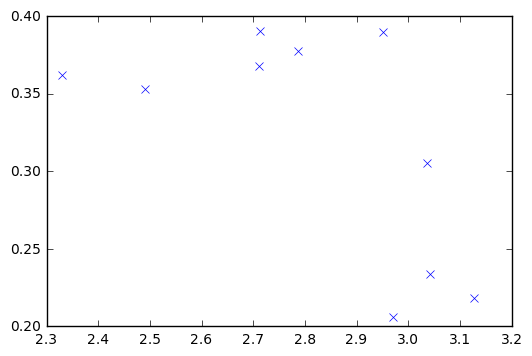

In [31]:
plt.plot(Measured, np.array(Mod)/np.array(Measured), 'x')

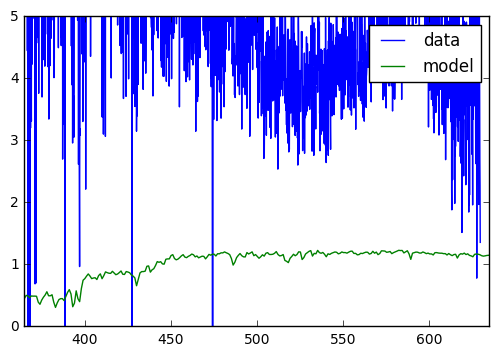

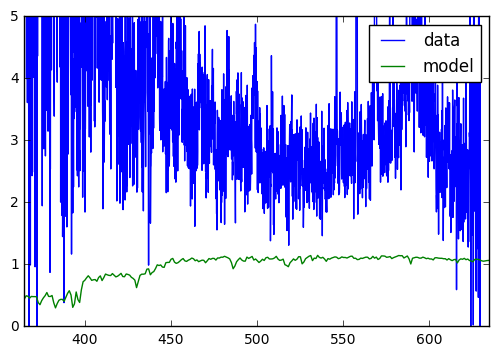

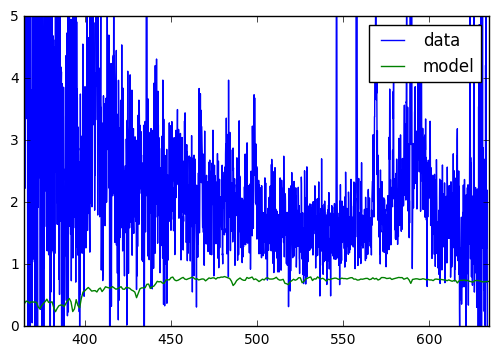

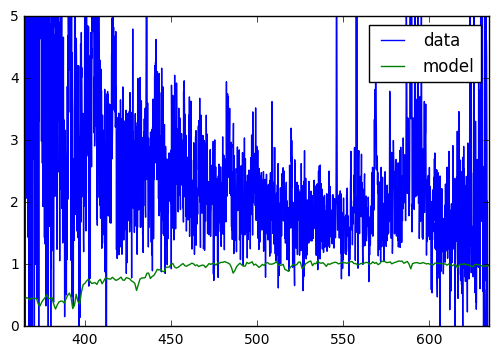

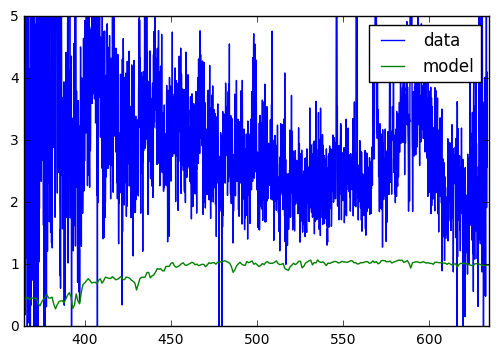

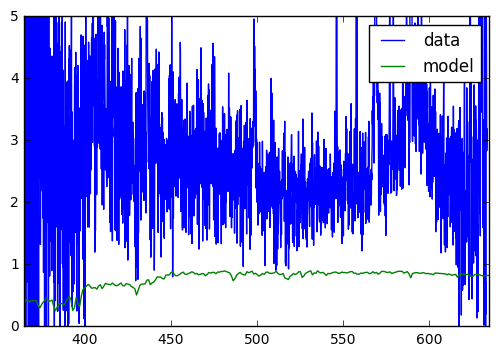

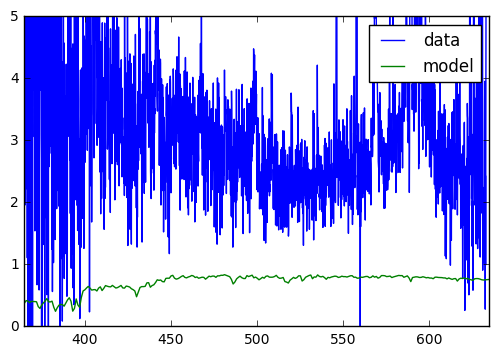

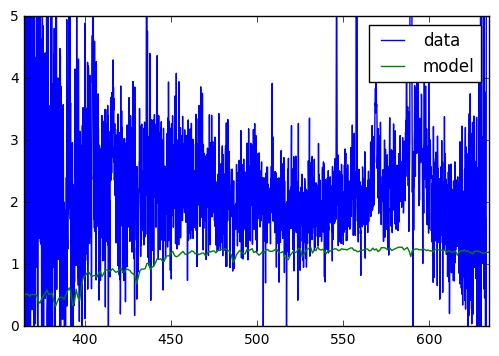

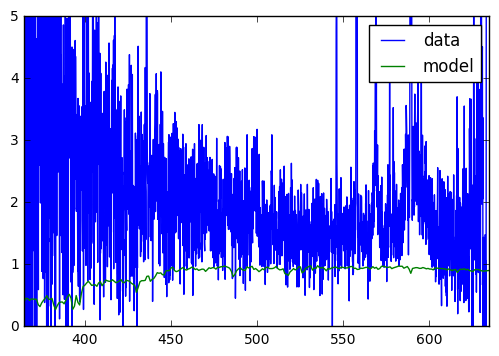

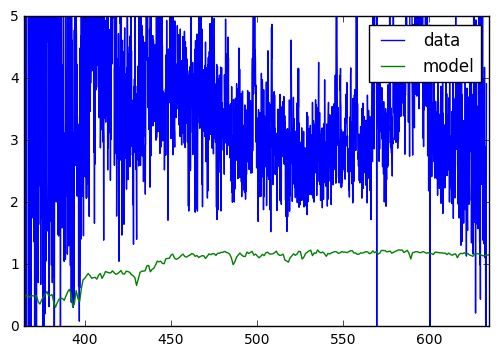

In [44]:
for i in np.random.randint(len(Clean_Dark),size=10):
    obs = Clean_Dark[i]
    data = np.load('/Volumes/PFagrelius_Backup/sky_data/sky_flux/%d_calibrated_sky.npy' % int(obs['PLATE']))
    spectrum = data[obs['SPECNO']]
    SM = SkyModel(obs)
    SM.run_model()
    plt.figure()
    plt.plot(spectrum['WAVE'], spectrum['SKY'], label = 'data')
    plt.plot(SM.Model['wave_range'], SM.Model['Zodi'], label = 'model')#%.2f, %.2f'% (SM.ObsMeta['HELIO_LON'],SM.ObsMeta['HELIO_LAT']))
    plt.xlim(365,635)
    plt.ylim(0,5)
    plt.legend()

## Look at LogIs for Blue Brights

In [57]:
import glob

In [58]:
cont_files = glob.glob('/Users/parkerf/Research/SkyModel/BOSS_Sky/FitSpectra/split_files/*_split_flux.fits')

In [59]:
logI = []
for filen in cont_files:
    hdulist = fits.open(filen)
    ObsMeta = astropy.table.Table(hdulist[1].data)
    observations = ObsMeta
    for obs in observations:
        ThisObs = SkyModel(obs)
        ThisObs.run_model()
        logI.append(ThisObs.Z.logI)

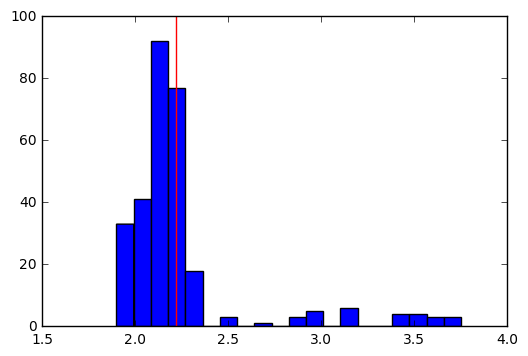

In [63]:
red = plt.hist(logI,20)
plt.axvline(2.22,color='red')